In [1]:
using Pkg
Pkg.activate("../../Project.toml")

using ITensors
using Plots
using Random
using Interpolations
using LegendrePolynomials

include("../RealRealHighDimension.jl")
include("../benchmarking/benchUtils.jl")

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


get_baseKLD (generic function with 1 method)

In [2]:
function vis_dist(W::MPS, e::T, d::Integer; nxs=100) where {T<:Encoding}
    @assert !e.istimedependent
    a,b = e.range
    xs = range(a,b,nxs)
    x_encs = map(x->e.encode(x, d), xs)
    return vis_dist(W, e, d, xs, x_encs)
end

function vis_dist(W::MPS, e::T, d::Integer, xs::Vector{Float64}, x_encs::VecOrMat{Vector{N}}) where {T<:Encoding, N <: Number}
    dists = Vector{Float64}(undef, length(W))

    Wdag = dag(W)
    Wdagp = sim(siteinds, Wdag)
    Wdag = sim(linkinds, Wdag)

    prod = W .* Wdag;
    lcache = accumulate(*, prod)
    rcache = reverse(accumulate(*,prod[end:-1:1]))
    
    outs = []
    
    for (i, it) in enumerate(W)
        if x_encs isa Matrix #e.istimedependent
            con_xs = [ W[i] * itensor(xe, siteinds(W)[i]) for xe in x_encs[i,:]]
            con_xdags = [ Wdag[i] * dag(itensor(xe, siteinds(Wdag)[i])) for xe in x_encs[i,:]]
        else
            con_xs = [ W[i] * itensor(xe, siteinds(W)[i]) for xe in x_encs]
            con_xdags = [ Wdag[i] * dag(itensor(xe, siteinds(Wdag)[i])) for xe in x_encs]
        end
        
        if i == 1
            cache =  rcache[i+1] 
        elseif i == length(W)
            cache = lcache[i-1] 
        else
            cache = lcache[i-1] * rcache[i+1] 
        end

        tensor = map((x1,x2) -> real(first(cache * x1 * x2)), con_xs, con_xdags)
        push!(outs, tensor)
    end
    return [xs, hcat(outs...)]
end

function vis_dist(X_train, y_train, X_val, y_val, X_test, y_test, encoding::T, d::Integer, ; aux_basis_dim=2, nsweeps=5, chi_max=15, eta=0.025, update_iters=1, verbosity=0, track_cost=false, grad_iter=KLD_iter) where {T<:Encoding}



    scaler = fit(RobustSigmoid, X_train; range=encoding.range);
        X_train_scaled = transform_data(scaler, X_train)
        X_val_scaled = transform_data(scaler, X_val)
        X_test_scaled = transform_data(scaler, X_test);

    #
    dtype = encoding.iscomplex ? ComplexF64 : Float64

    opts=Options(; nsweeps=nsweeps, chi_max=chi_max,  update_iters=update_iters, verbosity=verbosity, dtype=dtype, lg_iter=grad_iter,
    bbopt=BBOpt("CustomGD", "TSGO"), track_cost=track_cost, eta=eta, rescale = (false, true), d=d, aux_basis_dim=aux_basis_dim, encoding=encoding)

    W, info, train_states, test_states, xs ,sample_encoding = fitMPS(X_train, y_train, X_val, y_val, X_test, y_test; random_state=456, chi_init=4, opts=opts, test_run=false, return_sample_encoding=true)
    
    
    # get the marginals
    mpss, l_ind = expand_label_index(W);



    _, outsC0 = vis_dist(mpss[1], encoding, d, xs, sample_encoding);
    _, outsC1 = vis_dist(mpss[2], encoding, d, xs, sample_encoding);

    return [xs, X_train_scaled, y_train, outsC0, outsC1, sample_encoding]


end

vis_dist (generic function with 3 methods)

In [3]:
function box_prob(nbins::Integer=20; domain::Tuple{Float64,Float64}=(0.,1.))
    @assert nbins % 2 == 0 "Number of nbins must be even to assure class is evenly weighted"
    class_one = sample(1:nbins,Int(nbins/2); replace=false)

    a, b = domain
    percentiles = range(a,b,nbins+1)[2:end]
    function prob(x; percentiles, class_one)
        arg = findfirst(p -> x <= p, percentiles)
        return Int(arg in class_one)
    end

    @show percentiles
    @show class_one
    return x -> prob(x;percentiles=percentiles, class_one=class_one)
end

box_prob (generic function with 2 methods)

percentiles = 0.05:0.05:1.0
class_one = [13, 16, 20, 5, 14, 2, 10, 9, 1, 6]


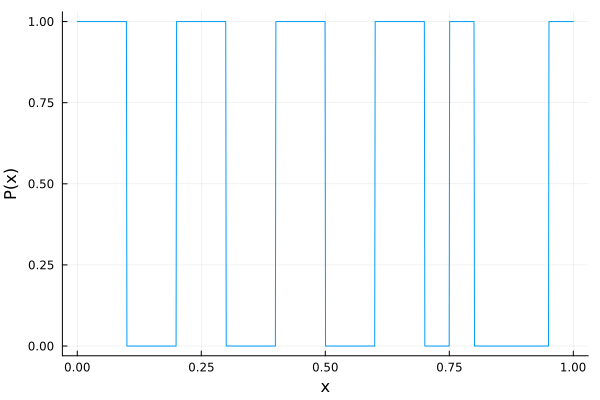

In [14]:
nxs = 1000
xs = range(0,1,nxs)
p = box_prob(20)
plot(xs, p.(xs), legend=:none, ylabel="P(x)", xlabel="x")

percentiles = 0.5:0.5:1.0
class_one = [2]


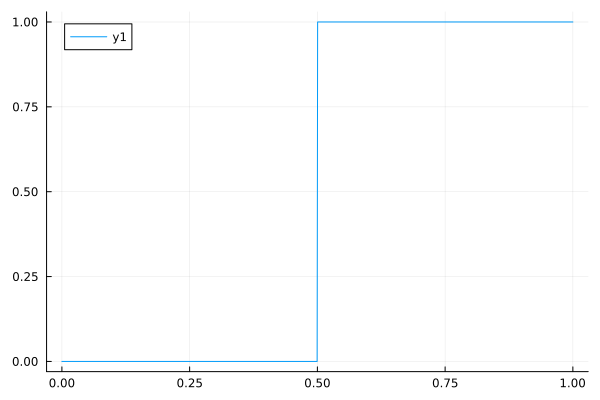

In [15]:
nseries = 20
nbins=2
nsites = 2
p = box_prob(nbins)
xs = rand(nseries)

y_train = p.(xs)
X_train = repeat(xs, 1, nsites) # the algorithm needs two sites lmao

xs = rand(nseries)
y_test = p.(xs)
X_test = repeat(xs, 1, nsites)

X_val, y_val = X_train, y_train

nxs = 1000
pxs = range(0,1,nxs)
plot(p, pxs)

In [28]:

encoding = Basis("Fourier")
d = 2
verbosity=1
#encoding = Basis("Legendre")
dtype = encoding.iscomplex ? ComplexF64 : Float64

xs, Xtrains, y_train, outsC0, outsC1, senc = vis_dist(X_train, y_train, X_val, y_val, X_test, y_test, encoding, d; nsweeps=20, chi_max=15, eta=0.05, track_cost=true)

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 456.
Initialising train states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │     9 │
│     1 │    11 │
└───────┴───────┘
Initialising valid states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │     9 │
│     1 │    11 │
└───────┴───────┘
Initialising test states.
Initialising test_enc states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │     9 │
│     1 │    11 │
└───────┴───────┘
Using 1 iterations per update.
Validation MSE loss: 0.5454519575058062 | Validation acc. 0.35.
Training MSE loss: 0.5454519575058062 | Training acc. 0.35.
Testing MSE loss: 0.5162793441056326 | Testing acc. 0.35.

Validation KL Divergence: 3.363124164204533.
Training KL Divergence: 3.363124164204533.
Test KL Divergence: 3.255261196510806.
Using optimiser CustomGD with the "TSGO" algorithm
Sta

6-element Vector{Array}:
 [-1.0, -0.9899497487437185, -0.9798994974874372, -0.9698492462311558, -0.9597989949748744, -0.949748743718593, -0.9396984924623115, -0.9296482412060302, -0.9195979899497487, -0.9095477386934674  …  0.9095477386934674, 0.9195979899497487, 0.9296482412060302, 0.9396984924623115, 0.949748743718593, 0.9597989949748744, 0.9698492462311558, 0.9798994974874372, 0.9899497487437185, 1.0]
 [0.3283008188392509 0.3283008188392509; 0.05265418358351015 0.05265418358351015; … ; 0.3475548776658548 0.3475548776658548; 0.4550416042934644 0.4550416042934644]
 [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]
 [0.22114254486249918 0.15193806949642866; 0.2141650305251941 0.14547892306080676; … ; 0.2281212219668243 0.15846736322515045; 0.22114254486249918 0.15193806949642866]
 [0.08549177444289097 0.1004564650655874; 0.09011878320336246 0.10565572075929885; … ; 0.08105635403116535 0.09543388059156224; 0.08549177444289097 0.1004564650655874]
 Vector{ComplexF64}[[-0.707106

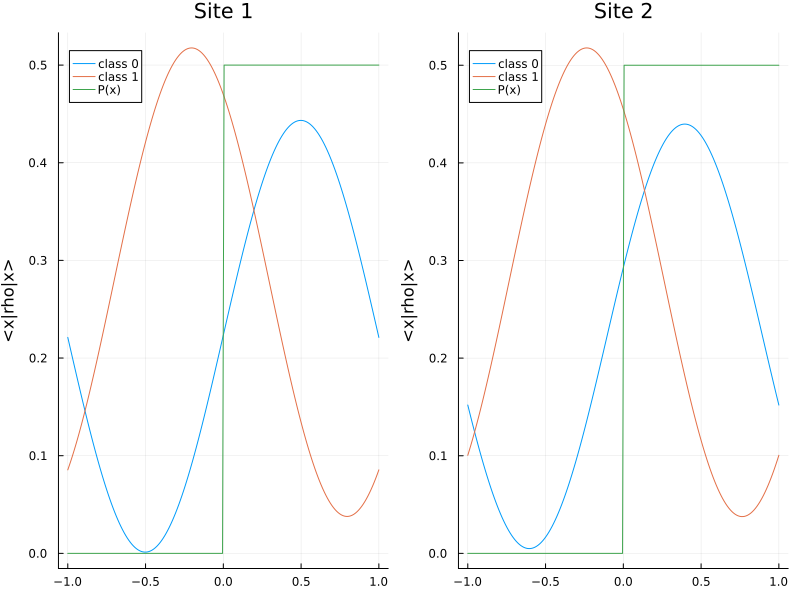

In [32]:
ps = []
for site in 1:2
    pl = plot(xs, outsC0[:,site], label="class 0", title="Site $site")
    plot!(xs, outsC1[:,site], label="class 1")
    plot!(x-> p((x/2+0.5))/2,xs, label="P(x)", ylabel = "<x|rho|x>")

    #scatter!(Xtrains[:,1], y_train./2, label="Timeseries values")

    push!(ps, pl)
end
plot(ps..., size=(800,600))


In [33]:
encoding = Basis("Legendre")
d = 2
verbosity=1
dtype = encoding.iscomplex ? ComplexF64 : Float64

xs, Xtrains, y_train, outsC0, outsC1, senc = vis_dist(X_train, y_train, X_val, y_val, X_test, y_test, encoding, d; nsweeps=20, chi_max=15, eta=0.05, track_cost=true)

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 456.
Initialising train states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │     9 │
│     1 │    11 │
└───────┴───────┘
Initialising valid states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │     9 │
│     1 │    11 │
└───────┴───────┘
Initialising test states.
Initialising test_enc states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │     9 │
│     1 │    11 │
└───────┴───────┘
Using 1 iterations per update.
Validation MSE loss: 0.45683644712095217 | Validation acc. 0.6.
Training MSE loss: 0.45683644712095217 | Training acc. 0.6.
Testing MSE loss: 0.4631329101844834 | Testing acc. 0.5.

Validation KL Divergence: 7.752637040212596.
Training KL Divergence: 7.752637040212596.
Test KL Divergence: 8.21873365317056.
Using optimiser CustomGD with the "TSGO" algorithm
Start

6-element Vector{Array}:
 [-1.0, -0.9899497487437185, -0.9798994974874372, -0.9698492462311558, -0.9597989949748744, -0.949748743718593, -0.9396984924623115, -0.9296482412060302, -0.9195979899497487, -0.9095477386934674  …  0.9095477386934674, 0.9195979899497487, 0.9296482412060302, 0.9396984924623115, 0.949748743718593, 0.9597989949748744, 0.9698492462311558, 0.9798994974874372, 0.9899497487437185, 1.0]
 [0.3283008188392509 0.3283008188392509; 0.05265418358351015 0.05265418358351015; … ; 0.3475548776658548 0.3475548776658548; 0.4550416042934644 0.4550416042934644]
 [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]
 [0.2893202876840952 0.25936559717285207; 0.2764091658408995 0.24802269049862077; … ; 0.2482154382450182 0.26806033166711496; 0.2599595288279531 0.28023266231680305]
 [0.6351232386398408 0.7097899387386853; 0.6025523285536878 0.6768410900180358; … ; 0.2121022011544798 0.07922408390902234; 0.22851109425660446 0.08743559609193094]
 [[-0.6887246539984297, 0.889139705

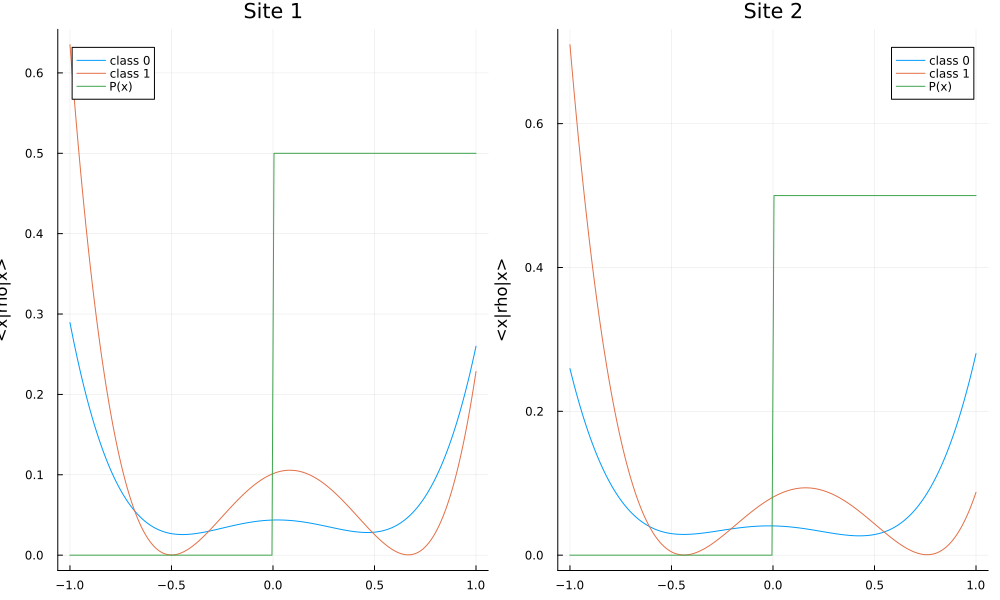

In [36]:
ps = []
for site in 1:2
    pl = plot(xs, outsC0[:,site], label="class 0", title="Site $site")
    plot!(xs, outsC1[:,site], label="class 1")
    plot!(x-> p((x/2+0.5))/2,xs, label="P(x)", ylabel = "<x|rho|x>")
    #scatter!(Xtrains[:,1], y_train./2, label="Timeseries values")
    push!(ps, pl)
end
plot(ps..., size=(1000,600))

In [22]:
scaler = fit(RobustSigmoid, X_train; range=encoding.range);
    transform_data(scaler, X_train)

50×2 Matrix{Float64}:
 -0.558481    -0.558481
  0.0054023    0.0054023
 -0.566287    -0.566287
  0.00205907   0.00205907
  0.285749     0.285749
 -0.561651    -0.561651
 -0.277601    -0.277601
  0.0842768    0.0842768
  0.446094     0.446094
  0.450806     0.450806
  ⋮           
 -0.409049    -0.409049
 -0.363635    -0.363635
 -0.116206    -0.116206
 -0.438791    -0.438791
  0.378104     0.378104
  0.469225     0.469225
 -0.46241     -0.46241
  0.513209     0.513209
  0.37893      0.37893

percentiles = 0.25:0.25:1.0
class_one = [4, 1]
Generating initial weight MPS with bond dimension χ_init = 4
        using random state 456.
Initialising train states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    27 │
│     1 │    23 │
└───────┴───────┘
Initialising valid states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    27 │
│     1 │    23 │
└───────┴───────┘
Initialising test states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    23 │
│     1 │    27 │
└───────┴───────┘
Initialising test_enc states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    27 │
│     1 │    23 │
└───────┴───────┘
Using 1 iterations per update.
Validation MSE loss: 0.49952891408276584 | Validation acc. 0.48.
Training MSE loss: 0.49952891408276584 | Training acc. 0.48.
Testing MSE loss: 0.49115421319082964 | Testing acc. 0.56

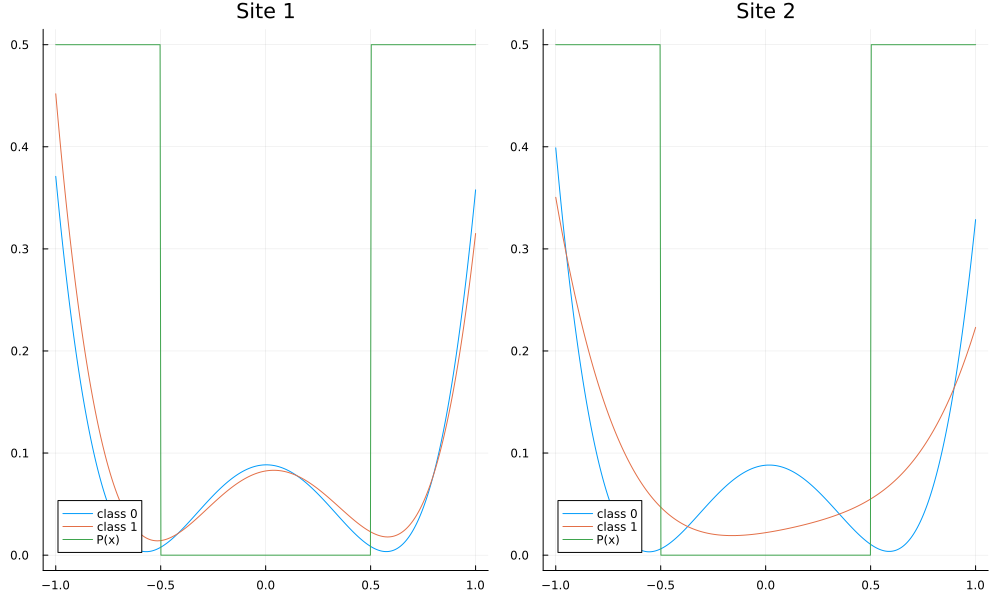

In [11]:
nseries = 50
nbins=4
nsites = 2
p = box_prob(nbins)
xs = rand(nseries)

y_train = p.(xs)
X_train = repeat(xs, 1, nsites) # the algorithm needs two sites lmao

xs = rand(nseries)
y_test = p.(xs)
X_test = repeat(xs, 1, nsites)

X_val, y_val = X_train, y_train

nxs = 1000
pxs = range(0,1,nxs)
plot(p, pxs)
encoding = Basis("Legendre")
d = 2
verbosity=1
dtype = encoding.iscomplex ? ComplexF64 : Float64

xs, Xtrains, y_train, outsC0, outsC1, senc = vis_dist(X_train, y_train, X_val, y_val, X_test, y_test, encoding, d; nsweeps=20, chi_max=15, eta=0.05, track_cost=true)

ps = []
for site in 1:2
    pl = plot(xs, outsC0[:,site], label="class 0", title="Site $site")
    plot!(xs, outsC1[:,site], label="class 1")
    plot!(x-> p((x/2+0.5))/2,xs, label="P(x)")
    push!(ps, pl)
end
plot(ps..., size=(1000,600))

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 456.
Initialising train states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    27 │
│     1 │    23 │
└───────┴───────┘
Initialising valid states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    27 │
│     1 │    23 │
└───────┴───────┘
Initialising test states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    23 │
│     1 │    27 │
└───────┴───────┘
Initialising test_enc states.
Classes are not Balanced:
┌───────┬───────┐
│ Class │ Count │
├───────┼───────┤
│     0 │    27 │
│     1 │    23 │
└───────┴───────┘
Using 1 iterations per update.
Validation MSE loss: 0.6803661445047579 | Validation acc. 0.38.
Training MSE loss: 0.6803661445047579 | Training acc. 0.38.
Testing MSE loss: 0.6990472249057974 | Testing acc. 0.38.

Validation KL Divergence: 2.247149417404795.
Tr

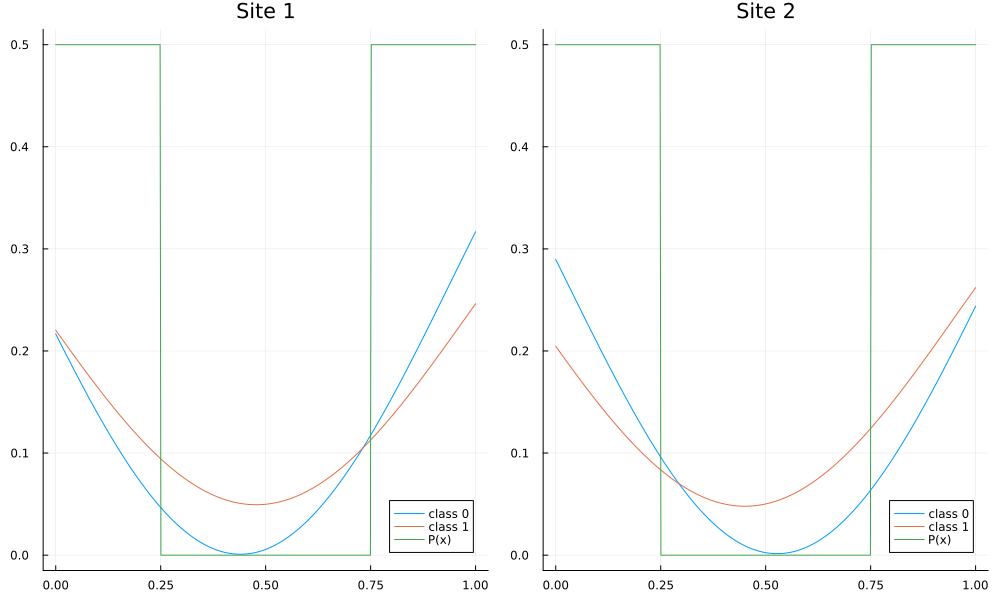

In [60]:
encoding = Basis("Fourier")
d = 2
verbosity=1
dtype = encoding.iscomplex ? ComplexF64 : Float64

xs, Xtrains, y_train, outsC0, outsC1, senc = vis_dist(X_train, y_train, X_val, y_val, X_test, y_test, encoding, d; nsweeps=20, chi_max=15, eta=0.05, track_cost=true)

ps = []
for site in 1:2
    pl = plot(xs, outsC0[:,site], label="class 0", title="Site $site")
    plot!(xs, outsC1[:,site], label="class 1")
    plot!(x-> p(x)/2,xs, label="P(x)")
    push!(ps, pl)
end
plot(ps..., size=(1000,600))